# **Word-Level LSTM Language Model**

## **From Scratch Implementation in NumPy**

This notebook implements a **vanilla LSTM** for word-level language modeling with word embeddings.

### **What We'll Build:**
- **Vanilla LSTM** with three (forget, input, output) gates
- **Word embeddings** for efficient vocabulary representation
- **Backpropagation Through Time (BPTT)** for gradient computation
- **Word-level text generation** from learned patterns

---
*Notebook by*: Ahmad Raza [@ahmadrazacdx](https://github.com/ahmadrazacdx)<br>
*Date: 2025*  
*License: MIT*

In [1]:
import re
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8')

In [2]:
data = open('../data/thirsty_crow.txt', 'r').read()
words = re.findall(r"\w+|[.,!?'\";:]", data.lower())
SOS_TOKEN = '<SOS>'  # Start of Sequence
EOS_TOKEN = '<EOS>'  # End of Sequence
UNK_TOKEN = '<UNK>'  # Unknown word
vocab = [SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + sorted(list(set(words)))
data_size, vocab_size = len(words), len(vocab)
print(f'Data has {data_size} words, {vocab_size} unique (including special tokens).')
print(f'Special tokens: {vocab[:3]}')
print(f'Sample words: {vocab[3:13]}')

Data has 148 words, 90 unique (including special tokens).
Special tokens: ['<SOS>', '<EOS>', '<UNK>']
Sample words: ['!', ',', '.', 'a', 'after', 'an', 'and', 'at', 'away', 'beak']


In [3]:
word_to_ix = {w: i for i, w in enumerate(vocab)}

In [4]:
ix_to_word = {i: w for i, w in enumerate(vocab)}

### __HYPER-PARAMETERS__

In [5]:
lr = 1e-3 # learning rate
seq_len = 25 # times LSTM will be unrolled (Timesteps)
hidden_size = 100 # size of hidden units
embed_size = 100 # size of word embedding vector

### __MODEL PARAM INIT__
**Initializing weight matrices for the LSTM with word embeddings.**

**Embedding Matrix:**
- $\mathbf{W}_{emb} \in \mathbb{R}^{V \times E}$ Word embedding matrix (lookup table)

**Gate Weight Matrices (concatenated input $[\mathbf{h}_{t-1}; \mathbf{e}_t]$):**
- $\mathbf{W}_f \in \mathbb{R}^{H \times (H+E)}$ Forget gate weights
- $\mathbf{W}_i \in \mathbb{R}^{H \times (H+E)}$ Input gate weights
- $\mathbf{W}_c \in \mathbb{R}^{H \times (H+E)}$ Candidate cell state weights
- $\mathbf{W}_o \in \mathbb{R}^{H \times (H+E)}$ Output gate weights

**Output Layer:**
- $\mathbf{W}_y \in \mathbb{R}^{V \times H}$ Hidden-to-output weights

**Biases:**
- Gate biases: $\mathbf{b}_f, \mathbf{b}_i, \mathbf{b}_c, \mathbf{b}_o \in \mathbb{R}^{H \times 1}$
- Output bias:  $\mathbf{b}_y \in \mathbb{R}^{V \times 1}$

**Total parameters:** $VE + 4H(H+E) + VH + 4H + V$

**Where:**  
- $V$ = vocabulary size  
- $E$ = embedding dimension (100)  
- $H$ = hidden size (100)

In [6]:
Wemb = np.random.randn(vocab_size, embed_size) * 0.01  # word embeddings (V, E)
Wf = np.random.randn(hidden_size, hidden_size + embed_size) * 0.01  # Forget Gate weights (H, H+E)
Wi = np.random.randn(hidden_size, hidden_size + embed_size) * 0.01  # Input Gate weights (H, H+E)
Wc = np.random.randn(hidden_size, hidden_size + embed_size) * 0.01  # Candidate Cell State weights (H, H+E)
Wo = np.random.randn(hidden_size, hidden_size + embed_size) * 0.01  # Output Gate weights (H, H+E)
Wy = np.random.randn(vocab_size, hidden_size) * 0.01  # Prediction weights (V, H)
bf = np.ones((hidden_size, 1))  # Forget Gate bias (H, 1)
bi = np.zeros((hidden_size, 1))  # Input Gate bias (H, 1)
bo = np.zeros((hidden_size, 1))  # Output Gate bias (H, 1)
bc = np.zeros((hidden_size, 1))  # CCS bias (H, 1)
by = np.zeros((vocab_size, 1))  # prediction bias (V, 1)

In [7]:
print(f"""
Wemb: Word embeddings    : {Wemb.shape}
Wf: Forget Gate Weights  : {Wf.shape}
Wi: Input Gate Weights   : {Wi.shape}
Wc: CCS Weights          : {Wc.shape}
Wo: Output Gate Weights  : {Wo.shape}
Wy: Prediction Weights   : {Wy.shape}
bf: Forget Gate bias     : {bf.shape}
bi: Input Gate bias      : {bi.shape}
bc: CCS bias             : {bc.shape}
bo: Output Gate bias     : {bo.shape}
by: Prediction bias      : {by.shape}
""")


Wemb: Word embeddings    : (90, 100)
Wf: Forget Gate Weights  : (100, 200)
Wi: Input Gate Weights   : (100, 200)
Wc: CCS Weights          : (100, 200)
Wo: Output Gate Weights  : (100, 200)
Wy: Prediction Weights   : (90, 100)
bf: Forget Gate bias     : (100, 1)
bi: Input Gate bias      : (100, 1)
bc: CCS bias             : (100, 1)
bo: Output Gate bias     : (100, 1)
by: Prediction bias      : (90, 1)



### __ADAM OPTIMIZER INITIALIZATION__

In [8]:
# Adam hyperparameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Adam memory variables (first moment)
mWemb = np.zeros_like(Wemb)
mWf = np.zeros_like(Wf)
mWi = np.zeros_like(Wi)
mWc = np.zeros_like(Wc)
mWo = np.zeros_like(Wo)
mWy = np.zeros_like(Wy)
mbf = np.zeros_like(bf)
mbi = np.zeros_like(bi)
mbc = np.zeros_like(bc)
mbo = np.zeros_like(bo)
mby = np.zeros_like(by)

# Adam memory variables (second moment)
vWemb = np.zeros_like(Wemb)
vWf = np.zeros_like(Wf)
vWi = np.zeros_like(Wi)
vWc = np.zeros_like(Wc)
vWo = np.zeros_like(Wo)
vWy = np.zeros_like(Wy)
vbf = np.zeros_like(bf)
vbi = np.zeros_like(bi)
vbc = np.zeros_like(bc)
vbo = np.zeros_like(bo)
vby = np.zeros_like(by)
# Timestep counter for bias correction
t_adam = 0

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

### __SINGLE LSTM CELL WITH WORD EMBEDDINGS__

**LSTM Forward Pass Equations:**

$$
\begin{align}
\mathbf{e}_t &= \mathbf{W}_{emb}[word\_idx] \quad &\text{(word embedding lookup)} \\
\mathbf{z}_t &= [\mathbf{h}_{t-1}; \mathbf{e}_t] \quad &\text{(concatenated input)} \\
\mathbf{f}_t &= \sigma(\mathbf{W}_f \mathbf{z}_t + \mathbf{b}_f) \quad &\text{(forget gate)} \\
\mathbf{i}_t &= \sigma(\mathbf{W}_i \mathbf{z}_t + \mathbf{b}_i) \quad &\text{(input gate)} \\
\tilde{\mathbf{c}}_t &= \tanh(\mathbf{W}_c \mathbf{z}_t + \mathbf{b}_c) \quad &\text{(candidate cell state)} \\
\mathbf{c}_t &= \mathbf{f}_t \odot \mathbf{c}_{t-1} + \mathbf{i}_t \odot \tilde{\mathbf{c}}_t \quad &\text{(cell state update)} \\
\mathbf{o}_t &= \sigma(\mathbf{W}_o \mathbf{z}_t + \mathbf{b}_o) \quad &\text{(output gate)} \\
\mathbf{h}_t &= \mathbf{o}_t \odot \tanh(\mathbf{c}_t) \quad &\text{(hidden state)} \\
\mathbf{y}_t &= \mathbf{W}_y \mathbf{h}_t + \mathbf{b}_y \quad &\text{(output logits)}
\end{align}
$$

**Where:** $\sigma$ = sigmoid, $\odot$ = element-wise multiplication

**Reference:** Hochreiter & Schmidhuber (1997) - *Long Short-Term Memory*

In [10]:
def lstm(c_prev, h_prev, word_idx):
    """
    Single LSTM cell with embedding lookup

    Inputs:
        - c_prev: Previous cell state (H, 1)
        - h_prev: Previous hidden state (H, 1)
        - word_idx: Integer index of word in vocabulary

    Returns:
        - ft, it, cct, ot: Gate activations
        - ct: Current cell state (H, 1)
        - ht: Current hidden state (H, 1)
        - yt: Output logits (V, 1)
        - et: Word embedding (E, 1)
    """
    et = Wemb[word_idx].reshape(-1, 1)  # (E, 1)
    zt = np.concatenate((h_prev, et), axis=0) # (H,1):(E,1)= (H+E,1)
    # Forget Gate
    zf = np.dot(Wf, zt) + bf # (H,H+E)@(H+E,1)->(H,1)+(H,1)=(H,1)
    ft = sigmoid(zf) # (H,1)
    #Input Gate
    zi = np.dot(Wi, zt) + bi # (H,H+E)@(H+E,1)->(H,1)+(H,1)=(H,1)
    it = sigmoid(zi) # (H,1)
    #Candidate Cell State
    zc = np.dot(Wc, zt) + bc # (H,H+E)@(H+E,1)->(H,1)+(H,1)=(H,1)
    cct = np.tanh(zc) # (H,1)
    #Cell State
    ct = ft * c_prev + it * cct # (H,1)*(H,1)+(H,1)*(H,1)=(H,1)
    #Output Gate
    zo = np.dot(Wo, zt) + bo # (H,H+E)@(H+E,1)->(H,1)+(H,1)=(H,1)
    ot = sigmoid(zo) # (H,1)
    #Hidden State
    ht = ot * np.tanh(ct) # (H,1)*(H,1)=(H,1)
    #Output Logits
    yt = np.dot(Wy, ht) + by # #(V,H)@(H,1)->(V,1)+(V,1)=(V,1)
    return ft, it, cct, ot, ct, ht, yt, et

**Understanding the LSTM Cell with Embeddings:**

**What's happening here?**
- At each timestep $t$, the LSTM takes three inputs:
  1. Current word index → lookup in $\mathbf{W}_{emb}$ to get dense vector $\mathbf{e}_t$
  2. Previous hidden state $\mathbf{h}_{t-1}$ (short-term working memory)
  3. Previous cell state $\mathbf{c}_{t-1}$ (long-term memory)
  
- It outputs:
  1. New hidden state $\mathbf{h}_t$ (short-term working memory)
  2. New cell state $\mathbf{c}_t$ (long-term memory)
  3. Output logits $\mathbf{y}_t$ (before softmax)
  4. Embedding $\mathbf{e}_t$ (needed for backprop!)


### __FORWARD PASS__


In [11]:
def forward(inputs, targets, c_prev, h_prev):
    """
    Forward pass through LSTM Cell with word embeddings

    Inputs:
        - inputs: List of word indices, e.g., [5, 8, 12, 12, 15] for "once upon a time there"
        - targets: List of target word indices (inputs shifted by 1)
        - c_prev: Initial cell state from previous sequence, shape (H, 1)
        - h_prev: Initial hidden state from previous sequence, shape (H, 1)

    Returns:
        - word_indices: Dict of word indices {0: word_0, 1: word_1, ...}
        - et: Dict of word embeddings {0: e_0, 1: e_1, ...}
        - ht: Dict of hidden states {-1: h_init, 0: h_0, 1: h_1, ...}
        - ct: Dict of cell states {-1: c_init, 0: c_0, 1: c_1, ...}
        - yt: Dict of output logits {0: y_0, 1: y_1, ...}
        - probt: Dict of probability distributions {0: p_0, 1: p_1, ...}
        - loss: Total cross-entropy loss across all timesteps (scalar)
    """
    # Initialize storage dictionaries
    word_indices = {}  # Store word indices
    et = {}  # Store embeddings
    ft = {}  # Store forget gate values
    it = {}  # Store input gate values
    cct = {} # Store ccs values
    ot = {}  # Store output gate values
    ht = {}  # Store hidden states
    ct = {}  # Store cell states
    yt = {}  # Store output logits
    probt = {}  # Store probability distributions (after softmax)

    # Set initial hidden and cell state
    ht[-1] = np.copy(h_prev) #(H,1)
    ct[-1] = np.copy(c_prev) #(H,1)
    loss = 0
    # Loop through each timestep in the sequence
    for t in range(len(inputs)):
        # Step 1: Store word index
        word_indices[t] = inputs[t]
        # Step 2: Run LSTM cell (forward computation)
        ft[t], it[t], cct[t], ot[t], ct[t], ht[t], yt[t], et[t] = lstm(ct[t-1], ht[t-1], word_indices[t])
        # Step 3: Apply softmax to get probabilities
        probt[t] = softmax(yt[t])  # (V,1)
        # Step 4: Compute loss for this timestep
        loss += -np.log(probt[t][targets[t], 0]+ epsilon)

    cache = (h_prev, c_prev, ft, it, cct, ot)
    return word_indices, et, ht, ct, probt, loss, cache

### __BACKWARD PASS (BPTT FOR LSTM)__
**Complete LSTM Backpropagation Through Time Equations**
#### **Step 1: Output Layer Gradient (Softmax + Cross-Entropy)**

$$\frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} = \mathbf{p}_t - \mathbf{1}_{y^*_t}$$

Where $\mathbf{p}_t$ is the predicted probability distribution and $\mathbf{1}_{y^*_t}$ is the one-hot vector of the true label.

**Output layer weight gradients:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_y} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} \mathbf{h}_t^T$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_y} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t}$$

#### **Step 2: Hidden State Gradient**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} = \mathbf{W}_y^T \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} + \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t+1}}$$

The gradient flows from two sources:
- Current timestep's output loss (first term)
- Future timestep's hidden state (second term)


#### **Step 3: Output Gate Gradients**

Recall: $\mathbf{h}_t = \mathbf{o}_t \odot \tanh(\mathbf{c}_t)$

**Gradient w.r.t. output gate (after sigmoid):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{o}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \odot \tanh(\mathbf{c}_t)$$

**Gradient w.r.t. output gate pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_o} = \frac{\partial \mathcal{L}}{\partial \mathbf{o}_t} \odot \mathbf{o}_t \odot (1 - \mathbf{o}_t)$$

(Using sigmoid derivative: $\sigma'(z) = \sigma(z)(1-\sigma(z))$)

#### **Step 4: Cell State Gradient**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \odot \mathbf{o}_t \odot (1 - \tanh^2(\mathbf{c}_t)) + \frac{\partial \mathcal{L}}{\partial \mathbf{c}_{t+1}}$$

**Key Insight:** The cell state gradient $\frac{\partial \mathcal{L}}{\partial \mathbf{c}_t}$ flows through forget gates across timesteps, allowing long-range gradient propagation without vanishing!

#### **Step 5: Candidate Cell State Gradients**

Recall: $\mathbf{c}_t = \mathbf{f}_t \odot \mathbf{c}_{t-1} + \mathbf{i}_t \odot \tilde{\mathbf{c}}_t$
**Gradient w.r.t. candidate cell (after tanh):**
$$\frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{c}}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} \odot \mathbf{i}_t$$
**Gradient w.r.t. candidate cell pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_c} = \frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{c}}_t} \odot (1 - \tilde{\mathbf{c}}_t^2)$$

(Using tanh derivative: $\tanh'(z) = 1 - \tanh^2(z)$)
#### **Step 6: Input Gate Gradients**
**Gradient w.r.t. input gate (after sigmoid):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{i}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} \odot \tilde{\mathbf{c}}_t$$
**Gradient w.r.t. input gate pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_i} = \frac{\partial \mathcal{L}}{\partial \mathbf{i}_t} \odot \mathbf{i}_t \odot (1 - \mathbf{i}_t)$$
#### **Step 7: Forget Gate Gradients**
**Gradient w.r.t. forget gate (after sigmoid):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{f}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} \odot \mathbf{c}_{t-1}$$
**Gradient w.r.t. forget gate pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_f} = \frac{\partial \mathcal{L}}{\partial \mathbf{f}_t} \odot \mathbf{f}_t \odot (1 - \mathbf{f}_t)$$
#### **Step 8: Weight Matrix Gradients (All Gates)**
For each gate $g \in \{f, i, c, o\}$:
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_g} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_g} \mathbf{z}_t^T$$
$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_g} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_g}$$
Where $\mathbf{z}_t = [\mathbf{h}_{t-1}; \mathbf{e}_t]$ is the concatenated input (hidden state + word embedding).
#### **Step 9: Gradient to Previous Timestep**
**Gradient w.r.t. concatenated input:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_t} = \sum_{g \in \{f,i,c,o\}} \mathbf{W}_g^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_g}$$
**Split to get gradient for previous hidden state:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}_t}[0:H]$$
(First $H$ elements of $\frac{\partial \mathcal{L}}{\partial \mathbf{z}_t}$)
#### **Step 10: Cell State Gradient to Previous Timestep**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{c}_{t-1}} = \frac{\partial \mathcal{L}}{\partial \mathbf{c}_t} \odot \mathbf{f}_t$$
This gradient flows backward through time via the forget gate, enabling long-term memory.
**Implementation Note:** Gradients are accumulated across all timesteps (sums in Step 8), then clipped to prevent exploding gradients before parameter updates.

**Notation:**
- $\odot$ = element-wise multiplication
- $\sigma$ = sigmoid function
- $T$ = sequence length
- $H$ = hidden dimension

In [12]:
def backward(inputs, targets, word_indices, et, ht, ct, probt, cache):
    """
    Backpropagation Through Time (BPTT) for LSTM with word embeddings

    Inputs:
        - inputs: List of input word indices
        - targets: List of target word indices
        - word_indices: Dict of word indices from forward pass
        - et: Dict of word embeddings from forward pass
        - ht: Dict of hidden states from forward pass
        - ct: Dict of cell states from forward pass
        - probt: Dict of probability distributions from forward pass
        - cache: Tuple (h_prev, c_prev, ft, it, cct, ot) from forward pass

    Returns:
        - dWemb: Gradient w.r.t. word embeddings
        - dWf, dWi, dWc, dWo: Gradients for gate weight matrices
        - dWy: Gradient w.r.t. hidden-to-output weights
        - dbf, dbi, dbc, dbo: Gradients for gate biases
        - dby: Gradient w.r.t. output bias
    """
    h_prev, c_prev, ft, it, cct, ot = cache
    dWemb = np.zeros_like(Wemb)  # (V, E)
    dWf = np.zeros_like(Wf)  # (H, H+E)
    dWi = np.zeros_like(Wi)  # (H, H+E)
    dWc = np.zeros_like(Wc)  # (H, H+E)
    dWo = np.zeros_like(Wo)  # (H, H+E)
    dWy = np.zeros_like(Wy)  # (V, H)

    dbf = np.zeros_like(bf)  # (H, 1)
    dbi = np.zeros_like(bi)  # (H, 1)
    dbc = np.zeros_like(bc)  # (H, 1)
    dbo = np.zeros_like(bo)  # (H, 1)
    dby = np.zeros_like(by)  # (V, 1)

    # Gradient of hidden state and cell state at next timestep (initially zero)
    dh_next = np.zeros_like(ht[0])  # (H, 1)
    dc_next = np.zeros_like(ct[0])  # (H, 1)

    # Backpropagate through time (from last to first timestep)
    for t in reversed(range(len(inputs))):
        # Step 1: Gradient of loss w.r.t output probabilities
        dy = np.copy(probt[t])  # (V, 1)
        dy[targets[t]] -= 1  # Subtract 1 from correct class (cross-entropy gradient)

        # Step 2: Gradients for output layer (Wy, by)
        dWy += np.dot(dy, ht[t].T)  # (V,1)@(1,H) = (V,H)
        dby += dy  # (V, 1)

        # Step 3: Gradient w.r.t hidden state
        # Comes from two sources: current output and next timestep
        dh = np.dot(Wy.T, dy) + dh_next  # (H,V)@(V,1) + (H,1) = (H,1)

        # Step 4: Gradient w.r.t output gate
        tanh_ct = np.tanh(ct[t])  # (H, 1)
        do = dh * tanh_ct  # (H,1) * (H,1) = (H,1)
        dzo = do * ot[t] * (1 - ot[t])  # (H,1)*(H,1)*(H,1)=(H,1)

        # Step 5: Gradient w.r.t cell state
        dc = dh * ot[t] * (1 - tanh_ct**2)  # (H,1)*(H,1)*(H,1) = (H,1)
        dc = dc + dc_next  # gradient from next timestep will be added

        # Step 6: Gradient w.r.t candidate cell state
        dcc = dc * it[t]  # (H,1) * (H,1) = (H,1)
        dzcc = dcc * (1 - cct[t]**2)  # (H,1)

        # Step 7: Gradient w.r.t input gate
        di = dc * cct[t]  # (H,1) * (H,1) = (H,1)
        dzi = di * it[t] * (1 - it[t])  # (H,1)

        # Step 8: Gradient w.r.t forget gate
        df = dc * ct[t-1]  # (H,1) * (H,1) = (H,1)
        dzf = df * ft[t] * (1 - ft[t])  # (H,1)

        # Step 9: Create concatenated input [h_{t-1}, e_t]
        zt = np.concatenate((ht[t-1], et[t]), axis=0)  # (H+E, 1)

        # Step 10: Gradients for gate weight matrices and biases
        dWf += np.dot(dzf, zt.T)  # (H,1)@(1,H+E) = (H,H+E)
        dbf += dzf  # (H,1)

        dWi += np.dot(dzi, zt.T)  # (H,1)@(1,H+E) = (H,H+E)
        dbi += dzi  # (H,1)

        dWc += np.dot(dzcc, zt.T)  # (H,1)@(1,H+E) = (H,H+E)
        dbc += dzcc  # (H,1)

        dWo += np.dot(dzo, zt.T)  # (H,1)@(1,H+E) = (H,H+E)
        dbo += dzo  # (H,1)

        # Step 11: Gradient w.r.t concatenated input [h_t-1, e_t]
        dzt = np.dot(Wf.T, dzf) + np.dot(Wi.T, dzi) + np.dot(Wc.T, dzcc) + np.dot(Wo.T, dzo) #(H+E, 1)

        # Step 12: Split gradient and pass to previous timestep
        dh_next = dzt[:hidden_size, :]  # First H elements: (H,1)
        de = dzt[hidden_size:, :]  # Last E elements: (E,1)

        # Step 13: Accumulate gradient for word embedding
        # accumulate gradients for the same word across timesteps
        dWemb[word_indices[t]] += de.reshape(-1)  # (E,)

        # Step 14: Gradient w.r.t previous cell state
        dc_next = dc * ft[t]  # (H,1) * (H,1) = (H,1)

        # Clip gradients to prevent exploding gradients
    for dparam in [dWemb, dWf, dWi, dWc, dWo, dWy, dbf, dbi, dbc, dbo, dby]:
        np.clip(dparam, -5, 5, out=dparam)

    return dWemb, dWf, dWi, dWc, dWo, dWy, dbf, dbi, dbc, dbo, dby

### __UPDATE PARAMS WITH ADAM__

In [13]:
def update_parameters(dWemb, dWf, dWi, dWc, dWo, dWy, dbf, dbi, dbc, dbo, dby, learning_rate):
    """
    Update LSTM model parameters using Adam optimizer with bias correction

    Inputs:
        - dWemb: Gradient for word embeddings (V, E)
        - dWf: Gradient for forget gate weights (H, H+E)
        - dWi: Gradient for input gate weights (H, H+E)
        - dWc: Gradient for cell candidate weights (H, H+E)
        - dWo: Gradient for output gate weights (H, H+E)
        - dWy: Gradient for prediction weights (V, H)
        - dbf, dbi, dbc, dbo: Gradients for gate biases (H, 1)
        - dby: Gradient for output bias (V, 1)
        - learning_rate: Step size for parameter updates

    Returns:
        - None (updates global parameters in-place)
    """
    global Wemb, Wf, Wi, Wc, Wo, Wy, bf, bi, bc, bo, by
    global mWemb, mWf, mWi, mWc, mWo, mWy, mbf, mbi, mbc, mbo, mby
    global vWemb, vWf, vWi, vWc, vWo, vWy, vbf, vbi, vbc, vbo, vby
    global t_adam

    t_adam += 1
    params = [
        (Wemb, dWemb, mWemb, vWemb),
        (Wf, dWf, mWf, vWf),
        (Wi, dWi, mWi, vWi),
        (Wc, dWc, mWc, vWc),
        (Wo, dWo, mWo, vWo),
        (Wy, dWy, mWy, vWy),
        (bf, dbf, mbf, vbf),
        (bi, dbi, mbi, vbi),
        (bc, dbc, mbc, vbc),
        (bo, dbo, mbo, vbo),
        (by, dby, mby, vby)
    ]
    updated = []
    for param, grad, m, v in params:
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        # Bias correction
        m_corrected = m / (1 - beta1 ** t_adam)
        v_corrected = v / (1 - beta2 ** t_adam)
        param = param - learning_rate * m_corrected / (np.sqrt(v_corrected) + epsilon)
        updated.append((param, m, v))

    (Wemb, mWemb, vWemb), (Wf, mWf, vWf), (Wi, mWi, vWi), (Wc, mWc, vWc), (Wo, mWo, vWo), (Wy, mWy, vWy), \
    (bf, mbf, vbf), (bi, mbi, vbi), (bc, mbc, vbc), (bo, mbo, vbo), (by, mby, vby) = updated

### __TRAIN MODEL__


In [14]:
def train(words_list, num_iterations=1000, print_every=100, sample_every=100):
    """
    Train word-level LSTM language model

    Inputs:
        - words_list: List of words from training text
        - num_iterations: Number of training iterations (not full data passes)
        - print_every: Print loss every N iterations
        - sample_every: Generate sample text every N iterations

    Returns:
        - smooth_loss: Exponentially smoothed loss value

    Note: Both hidden state h_prev AND cell state c_prev are maintained across
          sequences for temporal continuity. Only reset when reaching end of
          data or on first iteration.
    """
    smooth_loss = -np.log(1.0 / vocab_size) * seq_len
    losses = []
    n = 0  # Iterations counter
    p = 0  # Data pointer (position in word_list)
    h_prev = np.zeros((hidden_size, 1))
    c_prev = np.zeros((hidden_size, 1))

    while n < num_iterations:
        # Reset pointer, hidden state, AND cell state at end of data or first iteration
        if p + seq_len + 1 >= len(words_list) or n == 0:
            h_prev = np.zeros((hidden_size, 1))  # Fresh start
            c_prev = np.zeros((hidden_size, 1))  # Fresh cell state
            p = 0  # Go back to beginning

        # Input:  words at positions [p, p+1, ..., p+seq_len-1]
        # Target: words at positions [p+1, p+2, ..., p+seq_len]
        inputs = [word_to_ix[w] for w in words_list[p:p+seq_len]]
        targets = [word_to_ix[w] for w in words_list[p+1:p+seq_len+1]]

        # Forward pass (pass both hidden state AND cell state!)
        word_indices, et, ht, ct, probt, loss, cache = forward(inputs, targets, c_prev, h_prev)

        # Update hidden state AND cell state for next sequence
        h_prev = np.copy(ht[len(inputs) - 1])
        c_prev = np.copy(ct[len(inputs) - 1])

        # Backward pass
        dWemb, dWf, dWi, dWc, dWo, dWy, dbf, dbi, dbc, dbo, dby = backward(inputs, targets, word_indices, et, ht, ct, probt, cache)

        # Update parameters
        update_parameters(dWemb, dWf, dWi, dWc, dWo, dWy, dbf, dbi, dbc, dbo, dby, lr)

        # Update smooth loss
        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        losses.append(smooth_loss)
        # Print progress
        if n % print_every == 0:
            print(f"Iter {n:6d} | Loss: {smooth_loss:.4f}")
        # Generate sample text
        if n % sample_every == 0 and n > 0:
            print(f"\n{'='*60}")
            print(f"SAMPLE at iteration {n}:")
            print(f"{'='*60}")
            sample_text = sample(seed_word=None, n_words=50)
            print(sample_text)
            print(f"{'='*60}\n")
        p += seq_len

        n += 1
    print("\nTraining complete!")
    return smooth_loss, losses

### __SAMPLING FUNCTION (GENERATE TEXT)__

In [15]:
def sample(seed_word=None, n_words=50, use_sos=True, stop_at_eos=True):
    """
    Generate text by sampling from the trained word-level LSTM language model

    Inputs:
        - seed_word: Starting word for text generation (if None, uses <SOS>)
        - n_words: Maximum number of words to generate (default 50)
        - use_sos: If True and seed_word is None, start with <SOS> token
        - stop_at_eos: If True, stop generation when <EOS> token is sampled

    Returns:
        - String of generated text
    """
    # Initialize with seed word or SOS token
    if seed_word is None:
        if use_sos:
            word_idx = word_to_ix[SOS_TOKEN]
            generated_words = []  # Don't include SOS in output
        else:
            # Start with first regular word (after special tokens)
            word_idx = word_to_ix[vocab[3]]
            generated_words = [ix_to_word[word_idx]]
    else:
        # Handle seed word not in vocabulary
        word_idx = word_to_ix.get(seed_word.lower(), word_to_ix[UNK_TOKEN])
        if word_idx == word_to_ix[UNK_TOKEN]:
            print(f"Warning: '{seed_word}' not in vocab. Using <UNK> token.")
        generated_words = [ix_to_word[word_idx]]

    h = np.zeros((hidden_size, 1))  # Initialize hidden state
    c = np.zeros((hidden_size, 1))  # Initialize cell state

    for _ in range(n_words):
        # Run LSTM cell
        _, _, _, _, c, h, y, _ = lstm(c, h, word_idx)
        p = softmax(y)
        word_idx = np.random.choice(range(vocab_size), p=p.ravel())
        word = ix_to_word[word_idx]
        if stop_at_eos and word == EOS_TOKEN:
            break
        # Skip adding special tokens to output
        if word not in [SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]:
            generated_words.append(word)

    return ' '.join(generated_words)

### __RUN TRAINING__

In [16]:
_, loss = train(words, 10000, print_every=500, sample_every=2000)

Iter      0 | Loss: 112.4952
Iter    500 | Loss: 101.4359
Iter   1000 | Loss: 76.1447
Iter   1500 | Loss: 50.9899
Iter   2000 | Loss: 32.7823

SAMPLE at iteration 2000:
and flew small small crow up looked small small small them away thirsty by moment . a long time , and a thought in brightly , and but after flying for a long under , the crow finally saw a pitcher a quickly flew down and thought little water at

Iter   2500 | Loss: 20.6978
Iter   3000 | Loss: 12.9231
Iter   3500 | Loss: 8.0341
Iter   4000 | Loss: 4.9949

SAMPLE at iteration 4000:
upon a time , on a very hot day , a thirsty crow was flying in search of water . the sun was shining brightly , and the poor crow was feeling tired and weak . after flying for a long time , the crow finally saw a pitcher lying

Iter   4500 | Loss: 3.1113
Iter   5000 | Loss: 1.9442
Iter   5500 | Loss: 1.2203
Iter   6000 | Loss: 0.7703

SAMPLE at iteration 6000:
got an picking up small small small

Iter   6500 | Loss: 0.4895
Iter   7000 | Loss: 0

### __PLOT LOSS CURVE__

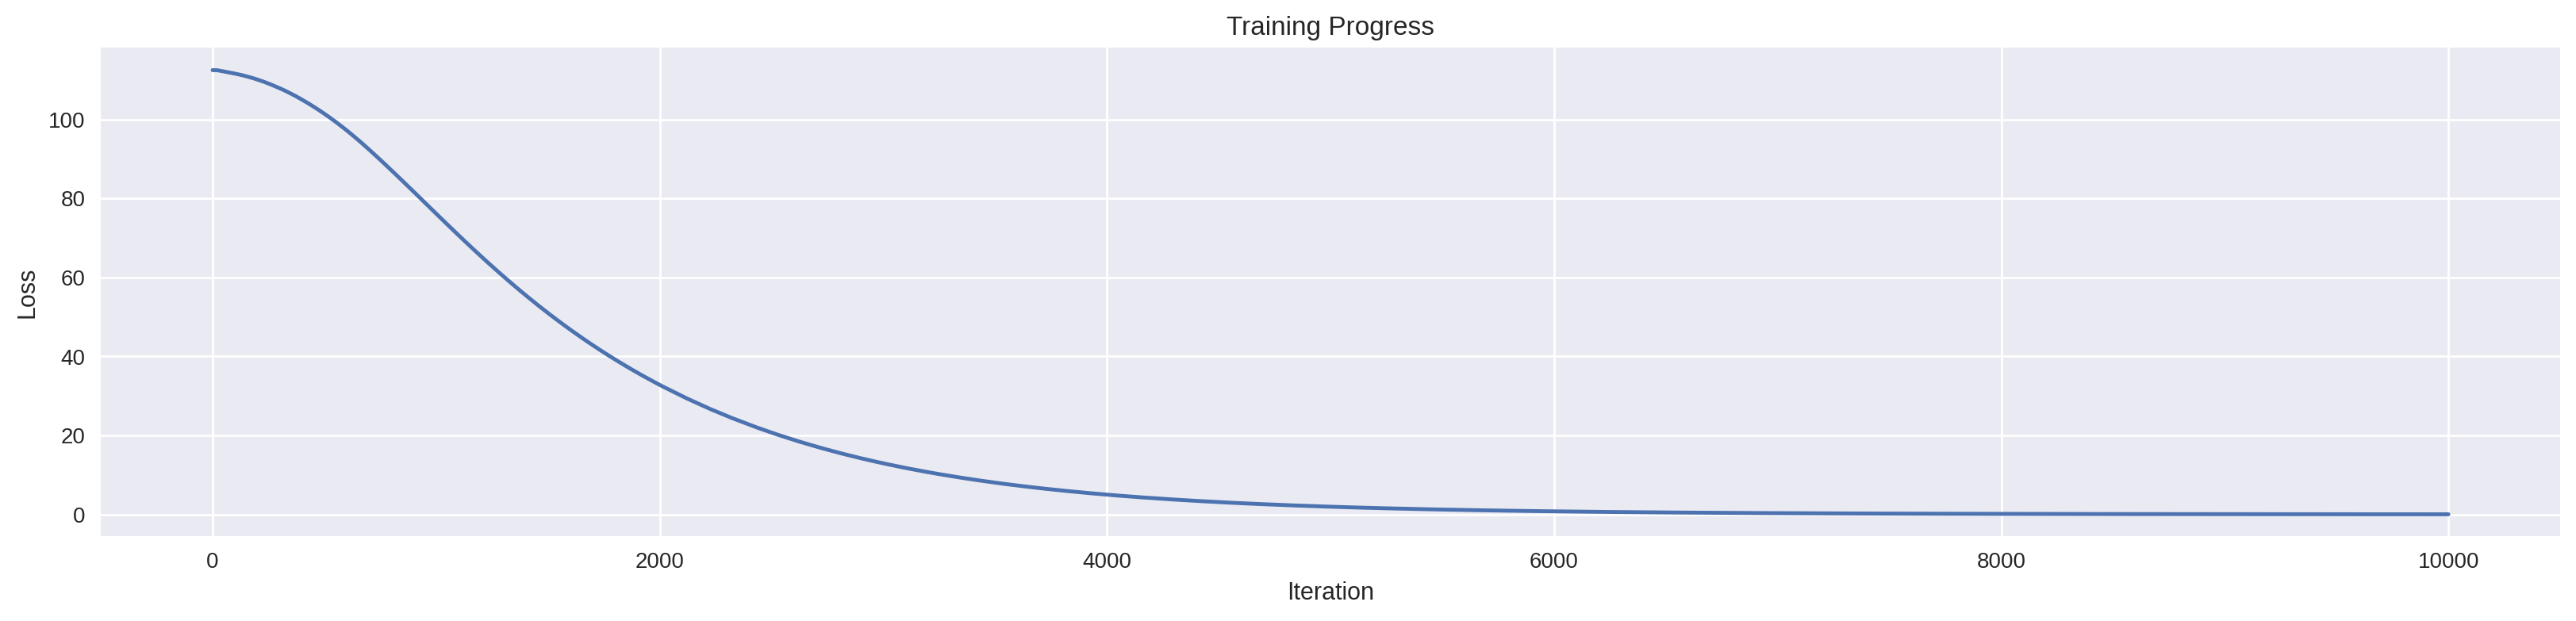

In [17]:
plt.figure(figsize=(20, 4))
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.show()

### __TEST DIFFERENT SEEDS__

In [18]:
seed_words = ['The', 'he', 'thirsty', 'wood', 'shiny']
for word in seed_words:
    generated_word = sample(word, n_words=150)
    print(word, ':', generated_word)
    print("-" * 60)

The : the search picking up small small pebbles small pebbles small continued water quickly picking up small small pebbles small was time upon upon upon upon a time , on a very hot day , a thirsty crow was flying in search of water . the sun was shining brightly , and the poor crow was feeling tired and weak . after flying for a long time , the crow finally saw a pitcher lying under a tree . he quickly flew down and looked inside . there was a little water at the bottom , but his beak could not reach it . the crow thought for a moment . then he got an idea ! he started picking up small pebbles one by one and dropped them into the pitcher . slowly , the water began to rise . the crow continued dropping stones until the water came came came
------------------------------------------------------------
he : he up small small small small small small small small pebbles tired pebbles small small small small small very small small small in he pitcher upon a time , on a very hot day , a thirst

In [19]:
# Test with SOS token (no seed word)
for i in range(3):
    generated = sample(seed_word=None, n_words=30, use_sos=True, stop_at_eos=True)
    print(f"Sample {i+1}: {generated}")
    print("-" * 60)

Sample 1: sun small upon upon a time , on a very hot day , a thirsty crow was flying in search of water . the sun was shining brightly , and
------------------------------------------------------------
Sample 2: finally an picking up small pebbles small was pitcher high beak up small pitcher finally saw reach upon a time , on a very hot day , a thirsty
------------------------------------------------------------
Sample 3: thought moment , a very hot day , a thirsty crow was flying in search of water . the sun was shining brightly , and the poor crow was feeling
------------------------------------------------------------


In [20]:
# Test with unknown word
generated = sample('elephant', n_words=30, stop_at_eos=True)
print(f"elephant: {generated}")
print("=" * 60)

elephant: <UNK> of small upon upon upon upon a time , on a very hot day , a thirsty crow was flying in search of water . the sun was shining brightly


### **References:**
1. Hochreiter, S., & Schmidhuber, J. (1997). *Long Short-Term Memory*. Neural Computation, 9(8), 1735-1780. [**Original LSTM Paper**]
2. Gers, F. A., et al. (2000). *Learning to Forget: Continual Prediction with LSTM*. Neural Computation, 12(10), 2451-2471.

### **Further Reading:**
1. Hochreiter & Schmidhuber (1997). [Long Short-Term Memory](https://www.bioinf.jku.at/publications/older/2604.pdf) — Original LSTM paper
2. Olah, C. (2015). [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) — Visual explanations
3. Cho et al. (2014). Learning Phrase Representations using RNN Encoder-Decoder for SMT — Introduced GRUs
4. Vaswani et al. (2017). Attention Is All You Need. NeurIPS — Transformers replacing LSTMs
5. Goodfellow et al. (2016). Deep Learning. Chapter 10: Sequence Modeling — Comprehensive theory
6. Graves, A. (2013). Generating Sequences With Recurrent Neural Networks — Advanced LSTM techniques